In [19]:
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm
import corner
import copy
import multiprocessing as mp
from tqdm import tqdm
from functools import partial

from hmc import HMC
from distributions import UnivariateNormal, IndependentMultivariateNormal, MultivariateNormal, HierarchicalBayesianLogisticRegression

In [20]:
sns.set()

In [11]:
# Get data for dts
def run_dt(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           L=5, 
           dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
           prop='leapfrog'):
    results = {}
    times = {}
    for d in dt:
        sampler = HMC(dist.logp, dist.dlogp, dt=d, L=L, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=True)
        times[d] = time.time() - time0
        results[d] = xs
    acc_dict = {}
    for d, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[d] = np.mean(acc_chain)
    return results, times, acc_dict

def run_L(data,
           dist, 
           M, 
           n_args, 
           steps,
           N_chains,
           init_x,
           Ls=np.arange(3, 8), 
           dt=1e-4, 
           prop='leapfrog'):
    results = {}
    times = {}
    for l in Ls:
        sampler = HMC(dist.logp, dist.dlogp, dt=dt, L=l, M=M, n_args=n_args, prop=prop)
        time0 = time.time()
        xs = sampler.sample_pool(steps, data, N_chains, init_x=init_x, verbose=True)
        times[l] = time.time() - time0
        results[l] = xs
    acc_dict = {}
    for l, xs in results.items():
        acc_chain = []
        for c in range(N_chains):
            acc_chain.append(len(np.unique(xs[c], axis=0)) / xs[c].shape[0])
        acc_dict[l] = np.mean(acc_chain)
    return results, times, acc_dict

In [21]:
def effective_sample_size(x, truncation=True, threshold=0.05):
    # A mapping from sample space to $R$
    # we use mean here
    M = len(x)
    if len(x.shape) > 1:
        f = x.mean(axis=-1)
    else:
        f = x
    
    # Compute mu, sigma
    mu_f = f.mean()
    var_f = f.var()
        
    ess = 0
    ro = np.zeros(M-1)
    temp = f - mu_f
    for s in range(M-1):
        ro[s] = temp[s+1:].dot(temp[:M-s-1]) / (var_f * (M-s-1))
    if truncation:
        M_cutoff = np.argmax(ro < threshold)
        ess = M / (1 + 2 * (1 - np.arange(1, M_cutoff+1) / M).dot(ro[:M_cutoff]))
    else:
        ess = M / (1 + 2 * (1 - np.arange(1, M) / M).dot(ro))
    return ess


"""
Special note: in original "No U-Turn" paper, ESS was computed
in two ways: 1. map from $R^d$ to $R$ then compute the ESS;
2. directly compute ESS on seperate dimensions
"""
def effective_sample_size_on_seperate_dimensions(x, truncation=True, threshold=0.05):
    if len(x.shape) > 1:
        res = []
        for i in range(x.shape[-1]):
            res.append(effective_sample_size(x[:, i]))
        return res
    else:
        return effective_sample_size(x, truncation, threshold)


def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size(xs[c]))
        ess[p] = np.mean(temp)
    return ess

In [13]:
N_chains = mp.cpu_count() - 1

In [14]:
# Parameters
dt = [10**c for c in np.arange(-6, -1, dtype=float)]
L = np.arange(3, 8)

# Sampling Example $\mathcal{N}(\mu,\sigma)$

In [8]:
# Generate observed data
truth = (0,1)

N = 10000
data = norm.rvs(loc=truth[0], scale=truth[1], size=N)
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.std(data)}')

mu_hat: 0.014285517948930621, sig_hat: 1.0007169918761623


In [9]:
# Initialize Distribution
dist = UnivariateNormal()

In [8]:
results_uni_dt_lp, times_uni_dt_lp, acc_uni_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

100%|██████████| 999/999 [00:05<00:00, 193.08it/s]


  0%|          | 0/999 [00:00<?, ?it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
/Users/glasschen/Documents/CS/co

In [9]:
results_uni_L_lp, times_uni_L_lp, acc_uni_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='leapfrog'
)

100%|██████████| 999/999 [00:05<00:00, 192.50it/s]

100%|██████████| 999/999 [00:05<00:00, 177.87it/s]

100%|██████████| 999/999 [00:06<00:00, 159.00it/s]

100%|██████████| 999/999 [00:06<00:00, 157.37it/s]

100%|██████████| 999/999 [00:06<00:00, 156.76it/s]


In [10]:
results_uni_dt_ys, times_uni_dt_ys, acc_uni_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5],
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

100%|██████████| 999/999 [00:07<00:00, 140.68it/s]

100%|██████████| 999/999 [00:06<00:00, 165.60it/s]

100%|██████████| 999/999 [00:07<00:00, 133.77it/s]


In [11]:
results_uni_L_ys, times_uni_L_ys, acc_uni_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(2), 
    n_args=2, 
    steps=10**3,
    N_chains=N_chains,
    init_x=[0.1,0.5], 
    prop='yoshida'
)

100%|██████████| 999/999 [00:08<00:00, 121.26it/s]


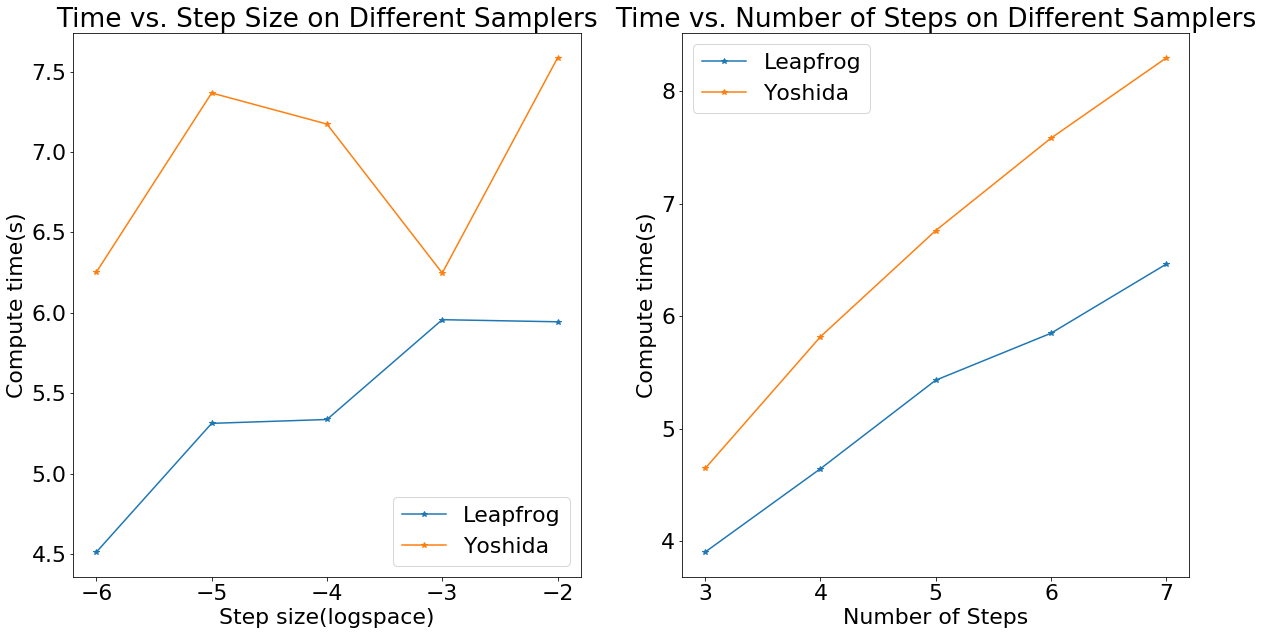

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_uni_dt_lp.keys())), list(times_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_uni_dt_ys.keys())), list(times_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_uni_L_lp.keys()), list(times_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_uni_L_ys.keys()), list(times_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 15})

In [26]:
average_ess(results_uni_dt_lp)

{1e-06: 2.9278852829709163,
 1e-05: 3.1172546070104232,
 0.0001: 27.948807419845902,
 0.001: 764.7949140347245,
 0.01: 1000.0}

In [28]:
average_ess(results_uni_dt_ys)

{1e-06: 2.8703527416086816,
 1e-05: 3.0865995004733606,
 0.0001: 36.11766374224798,
 0.001: 1000.0,
 0.01: 1000.0}

In [30]:
average_ess(results_uni_L_lp) 

{3: 12.323926928539722,
 4: 18.6814398457508,
 5: 32.88835931630593,
 6: 39.221830827254976,
 7: 56.424560678573705}

In [27]:
average_ess(results_uni_L_ys) 

{3: 11.484656179797858,
 4: 22.248851702473466,
 5: 25.45215095570091,
 6: 44.73410081892218,
 7: 45.38402776834387}

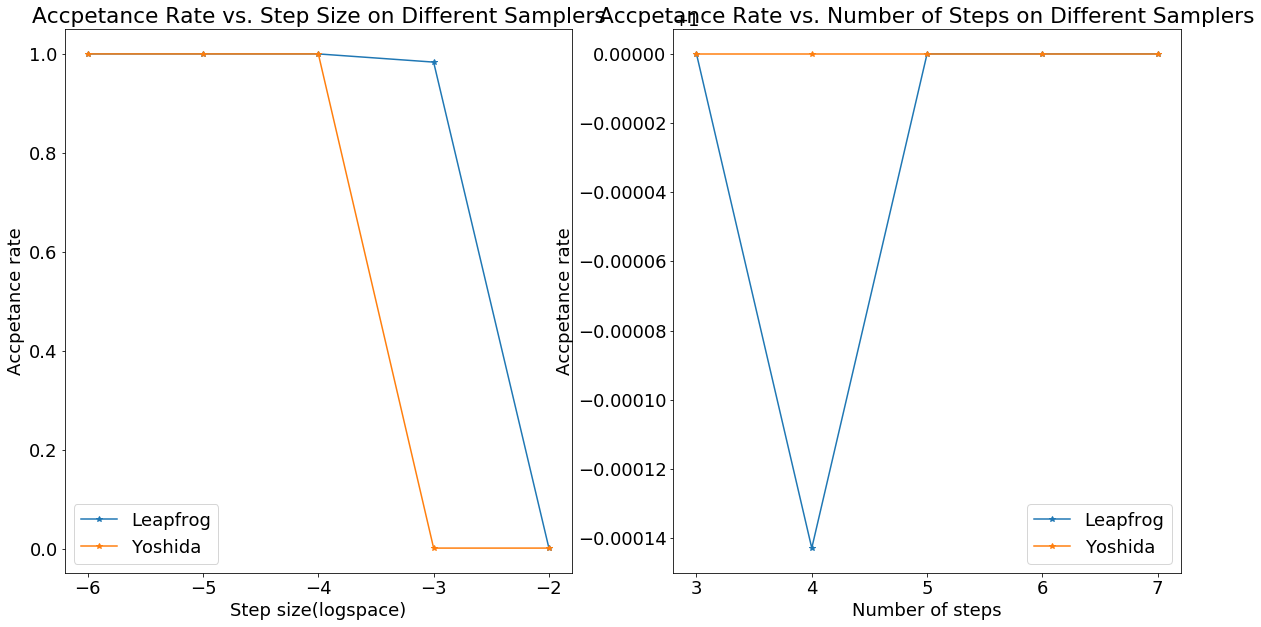

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_uni_dt_lp.keys())), list(acc_uni_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_uni_dt_ys.keys())), list(acc_uni_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_uni_L_lp.keys()), list(acc_uni_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_uni_L_ys.keys()), list(acc_uni_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rc('font', size=19)

In [5]:
# Generate observed data
ndims = 5 # Number of dimensions for multivariate Gaussian

mu_tru = 10*np.random.rand(ndims)
sig_tru = 5*np.random.rand(ndims)
N_chains = 3
N = 10000
data = mvnorm.rvs(mean=mu_tru, cov=np.diag(sig_tru), size=N)

print(f'mu_*: {mu_tru}, sig_*: {np.diag(sig_tru)}')
print(f'mu_hat: {np.mean(data)}, sig_hat: {np.cov(data)}')

mu_*: [0.0191759  8.12569867 4.48469147 1.99609609 3.83996953], sig_*: [[2.30766673 0.         0.         0.         0.        ]
 [0.         1.66701797 0.         0.         0.        ]
 [0.         0.         4.45721366 0.         0.        ]
 [0.         0.         0.         0.2515213  0.        ]
 [0.         0.         0.         0.         3.30206358]]
mu_hat: 3.693059717315295, sig_hat: [[21.07327137  9.12073197 14.62983036 ... 17.29110691 14.5757041
  12.46962939]
 [ 9.12073197  7.85706603  6.28948923 ...  5.26609463  5.27142239
   5.45466245]
 [14.62983036  6.28948923 10.39567805 ... 11.38950091  9.93449698
   9.03750875]
 ...
 [17.29110691  5.26609463 11.38950091 ... 18.45804115 12.62446833
   9.42107992]
 [14.5757041   5.27142239  9.93449698 ... 12.62446833 10.67082278
   8.21355702]
 [12.46962939  5.45466245  9.03750875 ...  9.42107992  8.21355702
   8.03369677]]


In [6]:
# Initialize Distribution
dist = IndependentMultivariateNormal(n_dims=ndims)

In [7]:
results_ind_dt_lp, times_ind_dt_lp, acc_ind_dt_lp = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='leapfrog'
)

100%|██████████| 999/999 [00:17<00:00, 56.43it/s]

100%|██████████| 999/999 [00:19<00:00, 50.83it/s]


In [16]:
def average_ess(results):
    ess = {}
    for p, xs in results.items():
        temp = []
        for c in range(N_chains):
            temp.append(effective_sample_size_on_seperate_dimensions(xs[c]))
        ess[p] = np.mean(temp)
    return ess

In [17]:
average_ess(results_ind_dt_lp)

/Users/glasschen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/glasschen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


{1e-06: 5.296991738627712,
 1e-05: 5.750985891313744,
 0.0001: 11.398856119569823,
 0.001: 126.28788459888024,
 0.01: 1000.0}

In [18]:
results_ind_L_lp, times_ind_L_lp, acc_ind_L_lp = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='leapfrog'
)

100%|██████████| 999/999 [00:19<00:00, 52.40it/s]

100%|██████████| 999/999 [00:27<00:00, 36.17it/s]


In [21]:
average_ess(results_ind_L_lp)

{3: 7.439297964614643,
 4: 9.23558099672153,
 5: 9.304640163095025,
 6: 17.454650853144916,
 7: 14.174493991026983}

In [22]:
results_ind_dt_ys, times_ind_dt_ys, acc_ind_dt_ys = run_dt(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   L=5, 
   dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
   prop='yoshida'
)

 23%|██▎       | 233/999 [00:08<00:25, 30.47it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
 35%|███▌      | 353/999 [00:12<00:21, 29.76it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/hmc.py:112: RuntimeWarning: overflow encountered in exp
  - self.U(xnew, data) - self.K(vnew))
100%|██████████| 999/999 [00:32<00:00, 30.85it/s]


In [25]:
average_ess(results_ind_dt_ys)

/Users/glasschen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/Users/glasschen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


{1e-06: 5.321387367529764,
 1e-05: 5.54380545947838,
 0.0001: 9.84357932969512,
 0.001: 135.88977103452606,
 0.01: 335.98237385016654}

In [26]:
results_ind_L_ys, times_ind_L_ys, acc_ind_L_ys = run_L(
   data,
   dist, 
   M=0.1*np.identity(2*ndims), 
   n_args=2*ndims, 
   steps=10**3,
   N_chains=N_chains,
   init_x=np.concatenate([mu_tru, sig_tru]),
   prop='yoshida'
)

100%|██████████| 999/999 [00:45<00:00, 22.14it/s]

100%|██████████| 999/999 [00:45<00:00, 22.07it/s]


In [31]:
import matplotlib

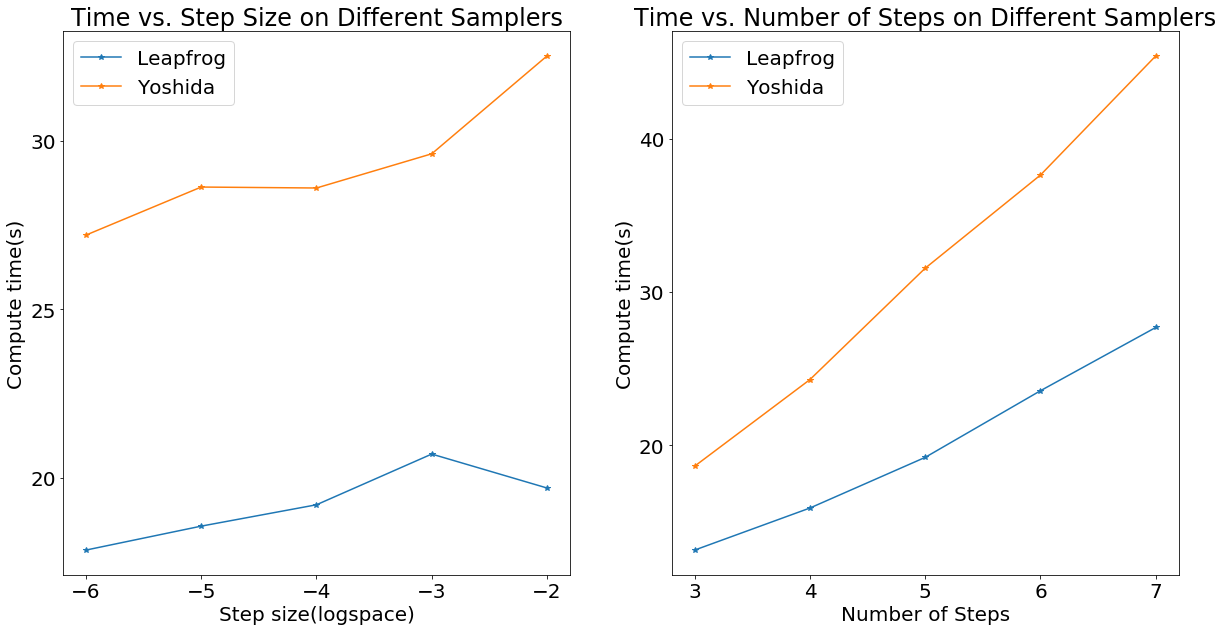

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_ind_dt_lp.keys())), list(times_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_ind_dt_ys.keys())), list(times_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_ind_L_lp.keys()), list(times_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_ind_L_ys.keys()), list(times_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 40})

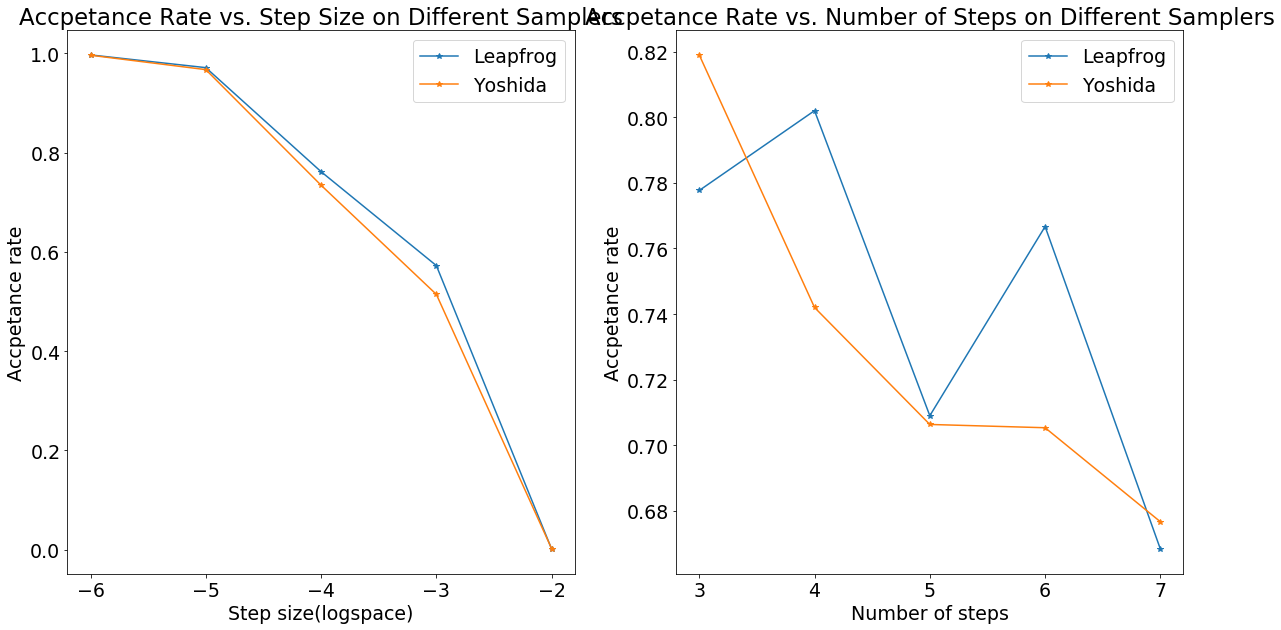

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_ind_dt_lp.keys())), list(acc_ind_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_ind_dt_ys.keys())), list(acc_ind_dt_ys.values()), '-*', label='Yoshida')
ax1.legend()
ax1.set_xticks(np.log10(list(times_ind_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_ind_L_lp.keys()), list(acc_ind_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_ind_L_ys.keys()), list(acc_ind_L_ys.values()), '-*', label='Yoshida')
ax2.legend()
ax2.set_xticks(list(times_ind_L_ys.keys()))

 # Sample **HLR**

In [15]:
# Read data
data = np.loadtxt('UCI_processed_data.txt')

In [16]:
# Initialize Distribution
dist = HierarchicalBayesianLogisticRegression(300)

In [17]:
init_x = np.random.randn(302)
init_x[-1] = 100

In [18]:
results_hlr_dt_lp, times_hlr_dt_lp, acc_hlr_dt_lp = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='leapfrog'
)

  0%|          | 0/999 [00:00<?, ?it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 0/999 [00:00<?, ?it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/999 [00:00<03:47,  4.39it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/glasschen/Documents/CS/courses/10708/symHMC/distribu

/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
  0%|          | 1/999 [00:00<03:45,  4.42it/s]/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
/Users/glasschen/Documents/CS/courses/10708/symHMC/distributions.py:133: RuntimeWarning: overflow encountered in exp
  dbeta = np.sum(y[:, None] * X / (np.exp(logits) + 1.)[:, None], 0) - beta / sigma_sq
100%|██████████| 999/999 [02:25<00:00,  6.84it/s]


In [23]:
times_uni_dt_lp

{1e-06: 132.8878390789032,
 1e-05: 148.9118721485138,
 0.0001: 153.83055090904236,
 0.001: 162.68757510185242,
 0.01: 146.18821573257446}

In [ ]:
results_hlr_dt_ys, times_hlr_dt_ys, acc_hlr_dt_ys = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='yoshida'
)

In [ ]:
results_hlr_dt_rt, times_hlr_dt_rt, acc_hlr_dt_rt = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='ruth'
)

In [ ]:
results_hlr_dt_ca, times_hlr_dt_ca, acc_hlr_dt_ca = run_dt(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x,
    L=5, 
    dt=[10**c for c in np.arange(-6, -1, dtype=float)], 
    prop='calvo'
)

In [ ]:
results_hlr_L_lp, times_hlr_L_lp, acc_hlr_L_lp = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='leapfrog'
)

In [ ]:
results_hlr_L_ys, times_hlr_L_ys, acc_hlr_L_ys = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='yoshida'
)

In [ ]:
results_hlr_L_rt, times_hlr_L_rt, acc_hlr_L_rt = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='ruth'
)

In [ ]:
results_hlr_L_ca, times_hlr_L_ca, acc_hlr_L_ca = run_L(
    data,
    dist, 
    M=0.1*np.identity(302), 
    n_args=302, 
    steps=10**4,
    N_chains=N_chains,
    init_x=init_x, 
    prop='calvo'
)

NameError: name 'times_hlr_dt_lp' is not defined

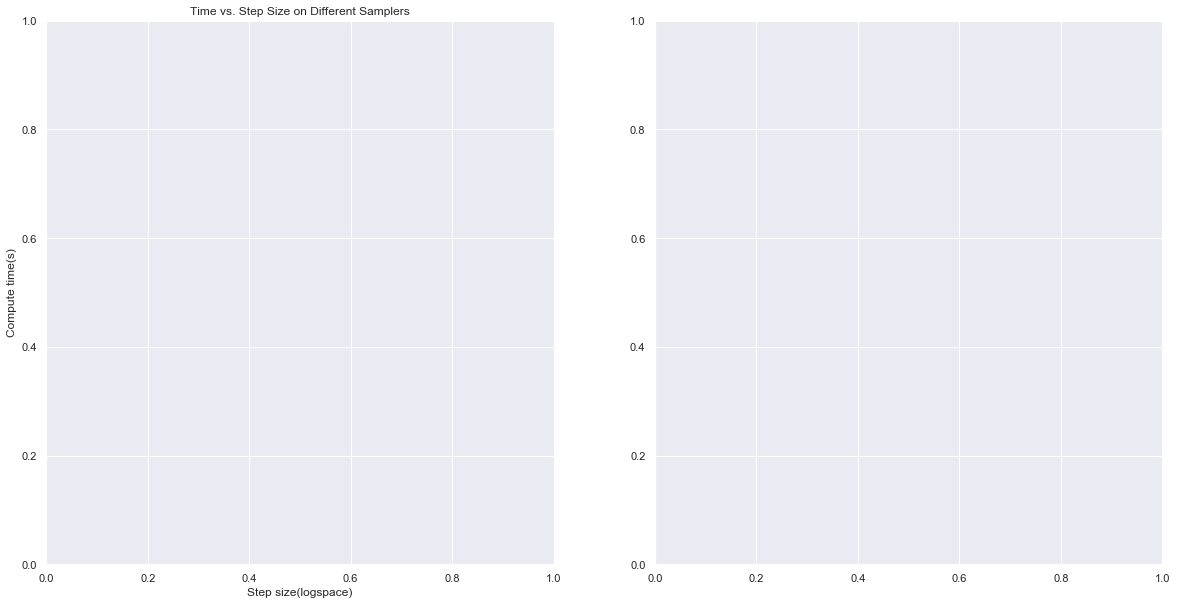

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Time vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Compute time(s)')
ax1.plot(np.log10(list(times_hlr_dt_lp.keys())), list(times_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(times_hlr_dt_ys.keys())), list(times_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(times_hlr_dt_rt.keys())), list(times_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(times_hlr_dt_ca.keys())), list(times_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Time vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of Steps')
ax2.set_ylabel('Compute time(s)')
ax2.plot(list(times_hlr_L_lp.keys()), list(times_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(times_hlr_L_ys.keys()), list(times_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(times_hlr_L_rt.keys()), list(times_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(times_hlr_L_ca.keys()), list(times_hlr_L_ca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rcParams.update({'font.size': 15})

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Accpetance Rate vs. Step Size on Different Samplers')
ax1.set_xlabel('Step size(logspace)')
ax1.set_ylabel('Accpetance rate')
ax1.plot(np.log10(list(acc_hlr_dt_lp.keys())), list(acc_hlr_dt_lp.values()), '-*', label='Leapfrog')
ax1.plot(np.log10(list(acc_hlr_dt_ys.keys())), list(acc_hlr_dt_ys.values()), '-*', label='Yoshida')
ax1.plot(np.log10(list(acc_hlr_dt_rt.keys())), list(acc_hlr_dt_rt.values()), '-*', label='Ruth')
ax1.plot(np.log10(list(acc_hlr_dt_ca.keys())), list(acc_hlr_dt_ca.values()), '-*', label='Calvo')
ax1.legend()
ax1.set_xticks(np.log10(list(times_uni_dt_lp.keys())))

ax2.set_title('Accpetance Rate vs. Number of Steps on Different Samplers')
ax2.set_xlabel('Number of steps')
ax2.set_ylabel('Accpetance rate')
ax2.plot(list(acc_hlr_L_lp.keys()), list(acc_hlr_L_lp.values()), '-*', label='Leapfrog')
ax2.plot(list(acc_hlr_L_ys.keys()), list(acc_hlr_L_ys.values()), '-*', label='Yoshida')
ax2.plot(list(acc_hlr_L_rt.keys()), list(acc_hlr_L_rt.values()), '-*', label='Ruth')
ax2.plot(list(acc_hlr_L_ca.keys()), list(acc_hlr_L_lpca.values()), '-*', label='Calvo')
ax2.legend()
ax2.set_xticks(list(times_uni_L_ys.keys()))
matplotlib.rc('font', size=19)

In [ ]:
average_ess(results_hlr_dt_lp)

In [ ]:
average_ess(results_hlr_dt_ys)

In [ ]:
average_ess(results_hlr_dt_rt)

In [ ]:
average_ess(results_hlr_dt_ca)

In [ ]:
average_ess(results_hlr_L_lp)

In [ ]:
results_hlr_L_ca